In [35]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable as V
import pandas as pd
import random
import itertools
import seaborn as sns
import time


In [301]:
def svcca(x, y, cutoff=0.99):
    
    u_x, s_x, v_x = torch.svd(x - x.mean(axis=0))
    u_y, s_y, v_y = torch.svd(y - y.mean(axis=0))
    
    var_x = torch.cumsum(s_x**2/torch.sum(s_x**2), dim=0)
    var_y = torch.cumsum(s_y**2/torch.sum(s_y**2), dim=0)
    
    u_1 = u_x[:,:torch.where(var_x > cutoff)[0][0]+1]
    u_2 = u_y[:,:torch.where(var_y > cutoff)[0][0]+1]
    
    s_1 = s_x[:torch.where(var_x > cutoff)[0][0]+1]
    s_2 = s_y[:torch.where(var_y > cutoff)[0][0]+1]
    
    v_1 = v_x[:,:torch.where(var_x > cutoff)[0][0]+1]
    v_2 = v_y[:,:torch.where(var_y > cutoff)[0][0]+1]
    
    uu = u_1.t() @ u_2
    u, diag, v = torch.svd(uu)
    a = (v_1 * s_1.reciprocal_().unsqueeze_(0)) @ u
    b = (v_2 * s_2.reciprocal_().unsqueeze_(0)) @ v
    return a, b, diag

def tensor_distance(x, y):
    sh = x.shape
    fltx = x.view(1, sh[0]*sh[1])
    flty = y.view(1, sh[0]*sh[1])
    return torch.cdist(fltx, flty)


def plot_tuning(learner_l, config, num_tasks):
    
    learner_u = MetaLearner(config)
    learner_u.train(0)
    learn = []
    blank = []
    nr = num_tasks
    tasks = [SineTask() for m in range(nr)]
    it = 11
    
    for task in tasks:
            learn.append(learner_l.fine_tune(task, shots=10, gradient_steps=it-1))
            blank.append(learner_u.fine_tune(task, shots=10, gradient_steps=it-1))
            
    
    s_x = pd.Series(['trained' for i in range(nr*it)], name = 'mode')
    s_y = pd.Series(['untrained' for i in range(nr*it)], name = 'mode')

    st1 = pd.DataFrame(np.array([(k+1) for k,i in itertools.product(range(it),range(nr))]),columns=['steps'])
    st2 = pd.DataFrame(np.array([i for k,i in itertools.product(range(it),range(nr))]),columns=['tasks']) 
    st3 = pd.DataFrame(np.array(learn).T.reshape(nr*it,1),columns=['mse loss'])

    su1 = pd.DataFrame(np.array([(k+1) for k,i in itertools.product(range(it),range(nr))]),columns=['steps'])
    su2 = pd.DataFrame(np.array([i for k,i in itertools.product(range(it),range(nr))]),columns=['tasks']) 
    su3 = pd.DataFrame(np.array(blank).T.reshape(nr*it,1),columns=['mse loss'])

    t_nice = pd.concat([s_x,st1,st2,st3], axis=1)
    u_nice = pd.concat([s_y,su1,su2,su3], axis=1)

    res = pd.concat([t_nice, u_nice], axis=0)
    sns.set_style("whitegrid")
    sns.lineplot(data=res, x="steps", y="mse loss", hue="mode")
    return res

In [302]:
class SineTask:
    def __init__(self):
        self.amplitude = np.random.uniform(0.1, 5.0)
        self.phase = np.random.uniform(0, np.pi)
        self.hold_x = None
        
    def sin(self, x):
        return self.amplitude * np.sin(x + self.phase)
    
    def training_data(self, n=10, fresh = False):
        if self.hold_x is None:
            self.hold_x = np.random.uniform(-5, 5, size=(n,1))
            x = self.hold_x
        else:
            if fresh:
                x = np.random.uniform(-5, 5, size=(n,1))
            else:
                x = self.hold_x
        y = self.sin(x)
        return torch.Tensor(x), torch.Tensor(y)
            
        
    def test_data(self, n=50):
        x = np.linspace(-5, 5, num=n).reshape(n,1)
        y = self.sin(x)
        return torch.Tensor(x), torch.Tensor(y)
    
    
class SineModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = torch.nn.Linear(1, 40)
        self.relu1 = torch.nn.ReLU()
        self.layer2 = torch.nn.Linear(40, 40)
        self.relu2 = torch.nn.ReLU()
        self.layer3 = torch.nn.Linear(40, 1)
        self.parameter_dict = {name: par for name, par in self.named_parameters()}
        self.activations_relu1 = []
        self.activations_relu2 = []
        self.activations_layer3 = []
        self.handles = []
    
    def forward(self, x, parameters=None):
        if parameters is None:
            x = self.layer1(x)
            x = self.relu1(x)
            x = self.layer2(x)
            x = self.relu2(x)
            x = self.layer3(x)
            return x
        else:
            x = F.linear(x, parameters['layer1.weight'], parameters['layer1.bias'])
            x = F.relu(x)
            x = F.linear(x, parameters['layer2.weight'], parameters['layer2.bias'])
            x = F.relu(x)
            x = F.linear(x, parameters['layer3.weight'], parameters['layer3.bias'])
            return x
                
    def get_parameter_dict(self):
        self.update_parameter_dict()
        return self.parameter_dict
    
    def get_activations(self, name):
        return getattr(self, 'activations_'+name)
    
    def update_parameter_dict(self):
        self.parameter_dict = {name: par for name, par in self.named_parameters()}

    def copy(self, model):
        self.load_state_dict(model.state_dict())
        
    def set_hooks(self):
        
        def hook_fn(name):
            def hook(model, input, output):
                getattr(self, 'activations_'+name).append(output.detach())
            return hook
            
        for name, module in self.named_modules():
            h = hook_fn(name)
            if name[:-1] == 'relu' or name == 'layer3':
                self.handles.append(getattr(self,name).register_forward_hook(h))
    
    def remove_hooks(self):
        for handle in self.handles:
            handle.remove()
        self.reset_activations()
    
    def reset_activations(self):
        for name, module in self.named_modules():
            if name[:-1] == 'relu' or name == 'layer3':
                getattr(self, 'activations_'+name).clear()

In [303]:
class MetaLearner:
    def __init__(self, config):
        self.config = config
        self.meta_model = SineModel()
        self.tuned_model = None
        self.meta_parameters = self.meta_model.get_parameter_dict()
        self.metric = torch.nn.MSELoss()
        self.activation = []
    
    def get_parameters(self): # depreciated
        self.update_meta_parameters()
        return self.meta_parameters
    
    def get_exp_results(self):
        return self.exp_results
    
    def update_meta_parameters(self):
        self.meta_parameters = self.meta_model.get_parameter_dict()
            
    def train(self, epochs=100, num_tasks=25, num_grad_steps=1, meta_lr=1e-3, step_lr=0.01, foa=False):
        self.epochs = epochs
        self.num_tasks = num_tasks
        self.meta_lr = meta_lr
        self.step_lr = step_lr
        self.foa = foa
        self.optimizer = torch.optim.Adam(self.meta_model.parameters(), lr=self.meta_lr)

        history = []
        self.optimizer.zero_grad()
        
        for epoch in range(self.epochs):
           
            task_batch_losses = []
            tasks = [SineTask() for m in range(self.num_tasks)]
            for task in tasks:
                
                task_model = SineModel()
                task_model.copy(self.meta_model)
                hold_parameters = self.meta_model.get_parameter_dict()
                for step in range(num_grad_steps):
                    
                    x, y = task.training_data()
                    y_hat = task_model.forward(x, hold_parameters)
                    loss = self.metric(y_hat, y)
                    grads = self.get_gradients(loss, hold_parameters)
                    for ((name, parameter), grad) in zip(hold_parameters.items(),grads):
                        hold_parameters[name] = parameter - self.step_lr * grad
                    
                x, y = task.training_data(fresh=True)
                y_hat = self.meta_model.forward(x, hold_parameters)
                meta_loss = self.metric(y_hat, y)
                meta_loss.backward(retain_graph=True)
                self.optimizer.step()
                self.optimizer.zero_grad()
                task_batch_losses.append(meta_loss.item())
                self.meta_model.update_parameter_dict()
                
            history.append(np.mean(task_batch_losses))
        
        return history
    
    def get_gradients(self, loss, parameters=None, fine_tune=False):
        # maml
        if self.config == 'maml':
            if fine_tune:
                grads = torch.autograd.grad(loss, self.tuned_model.parameters())
            else:
                grads = torch.autograd.grad(loss, parameters.values(), create_graph=not self.foa)
            return grads
        # anil      
        elif self.config == 'anil':
            grads = []
            if fine_tune:
                for name, parameter in self.tuned_model.named_parameters():
                    if 'layer3' in name:
                        grads.append(torch.autograd.grad(loss, parameter, retain_graph=True)[0])
                    else:
                        grads.append(torch.zeros_like(parameter))
            else:
                for name, parameter in parameters.items():
                    if 'layer3' in name:
                        grads.append(torch.autograd.grad(loss, parameter, create_graph=not self.foa)[0])
                    else:
                        grads.append(torch.zeros_like(parameter))
            return tuple(grads)
        else:
            print("ValueErro: only maml and anil are supported")
        
    def get_custom_gradients(self, loss, parameters=None, frozen=None):
        grads = []
        for name, parameter in self.tuned_model.get_parameter_dict().items(): #self.tuned_model.named_parameters():
            if name.split('.')[0] in frozen:
                grads.append(torch.zeros_like(parameter))
            else:
                grads.append(torch.autograd.grad(loss, parameter, create_graph=not self.foa)[0])
        return tuple(grads)
                
            
    def fine_tune(self, task, shots=5, gradient_steps=10, frozen=None):
        self.tuned_model = SineModel()
        self.tuned_model.copy(self.meta_model)
        tune_history = []
        
        for step in range(gradient_steps+1):
            x, y = task.training_data(n=shots)
            y_hat = self.tuned_model.forward(x)
            loss = self.metric(y_hat, y)
            if frozen is None or frozen[0]=='None':
                grads = self.get_gradients(loss, fine_tune=True) 
            else:
                grads = self.get_custom_gradients(loss, frozen=frozen)
            with torch.no_grad():
                for parameter, grad in zip(self.tuned_model.parameters(), grads):
                    parameter -= self.step_lr * grad
            if loss.item() > 100:
                print(loss.item())

            tune_history.append(loss.item())
        
        return tune_history
    
    
    def exp_freeze_layers(self, shots=5, num_tasks=10):
        tasks = [SineTask() for m in range(num_tasks)]
        hold_values = {'None': [],
                       'layer1': [],
                       'layer1 layer2': []}
        result = []
        for task in tasks:
            for name, value in hold_values.items():
                value.append(self.fine_tune(task, shots=shots, gradient_steps=10, frozen = name.split(' '))[-1])
        
        print("Over % 2d tasks" % num_tasks)
        for name, value in hold_values.items():
            print("mean mse of {0}: {1:1.4f} std mse of {2}: {3:1.4f}".format(name,np.mean(value),name,np.std(value)))
         #return hold_values   
    
    
    def exp_weight_distance(self, shots=10, num_tasks=10):
        tasks = [SineTask() for m in range(num_tasks)]
        hold_values = {'layer1': [],
                       'layer2': [],
                       'layer3': []}
        
        for task in tasks:
            self.fine_tune(task, shots=10, gradient_steps=10)
            for ((name, par1), par2) in zip(self.tuned_model.named_parameters(), self.meta_model.parameters()):
                if name.split('.')[1] == 'weight':
                    hold_values[name.split('.')[0]].append(tensor_distance(par1,par2)[0].detach().numpy()[0])
        
        print("Over % 2d tasks" % num_tasks)
        for name, value in hold_values.items():
            print("mean eucleadian distance of {0}: {1:1.4f} std eucleadian distance of {2}: {3:1.4f}".format(name,np.mean(value),name,np.std(value)))

    
    def exp_similarity_CCA(self, shots=10, num_tasks=10):
        
        tasks = [SineTask() for m in range(num_tasks)]
        hold_values = {'relu1': [],
                       'relu2': [],
                       'layer3':[]}
        for task in tasks:
            self.fine_tune(task, shots=shots, gradient_steps = 10)
            self.meta_model.set_hooks()
            self.tuned_model.set_hooks()
            
            x, _ = task.training_data(n=400, fresh=True)
            
            for x_i in x:
                self.meta_model(x_i)
                self.tuned_model(x_i)
                
            for name, modeule in self.meta_model.named_modules():
                if name[:-1] == 'relu' or name == 'layer3':
                    meta_act = torch.stack(self.meta_model.get_activations(name))
                    tuned_act = torch.stack(self.tuned_model.get_activations(name))
                    _, _, diag = svcca(meta_act, tuned_act)
                    hold_values[name].append(np.mean(diag.numpy()))
            self.meta_model.remove_hooks()
            self.tuned_model.remove_hooks()
            
        print("Over % 2d tasks" % num_tasks)
        for name, value in hold_values.items():
            print("mean cca of {0}: {1:1.4f} std cca of {2}: {3:1.4f}".format(name,np.mean(value),name,np.std(value)))
     
    

In [306]:
start = time.time()

epochs=5000 # even
num_tasks=10
num_grad_steps=1
meta_lr=1e-3
step_lr=0.01
foa = False
config = 'maml'

maml_learner = MetaLearner(config)
hist = maml_learner.train(epochs, num_tasks, num_grad_steps, meta_lr, step_lr, foa)


end = time.time()
print(end - start)



71.511394739151


In [ ]:
num_tasks_e = 100
res = plot_tuning(maml_learner, config, num_tasks_e) 

Freeze Layer, 5 shot and 10 shot
Over  25 tasks
mean mse of None: 0.3164 std mse of None: 0.3463
mean mse of layer1: 0.1800 std mse of layer1: 0.2436
mean mse of layer1 layer2: 0.3164 std mse of layer1 layer2: 0.3463
Over  25 tasks
mean mse of None: 0.9325 std mse of None: 0.9293
mean mse of layer1: 0.7235 std mse of layer1: 0.8687
mean mse of layer1 layer2: 0.9325 std mse of layer1 layer2: 0.9293
 
Similarity Tests (CCA), 5 shot and 10 shot
Over  25 tasks
mean cca of relu1: 1.0000 std cca of relu1: 0.0000
mean cca of relu2: 1.0000 std cca of relu2: 0.0000
mean cca of layer3: 0.6533 std cca of layer3: 0.2472
Over  25 tasks
mean cca of relu1: 1.0000 std cca of relu1: 0.0000
mean cca of relu2: 1.0000 std cca of relu2: 0.0000
mean cca of layer3: 0.5676 std cca of layer3: 0.2571
 
Eucleadian Distance Weights, 5 shot and 10 shot
Over  25 tasks
mean eucleadian distance of layer1: 0.0000 std eucleadian distance of layer1: 0.0000
mean eucleadian distance of layer2: 0.0000 std eucleadian distan

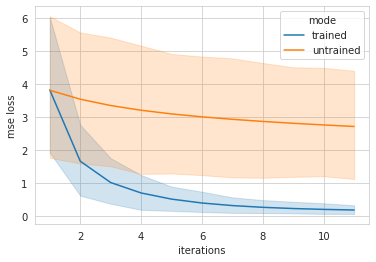

In [6]:
 
print('Freeze Layer, 5 shot and 10 shot')
# Freeze Layer Tests,  (Table: fixme)
# -----------------------------------
# 5 shots:
maml_learner.exp_freeze_layers(shots=5, num_tasks=num_tasks)
# 10 shots:
maml_learner.exp_freeze_layers(shots=10, num_tasks=num_tasks)

print(' ')
print('Similarity Tests (CCA), 5 shot and 10 shot')
# Similarity Tests (CCA), (Table: fixme)
# -----------------------------------
# 5 shots
maml_learner.exp_similarity_CCA(shots=5, num_tasks=num_tasks)
# 10 shots
maml_learner.exp_similarity_CCA(shots=10, num_tasks=num_tasks)

print(' ')
print('Eucleadian Distance Weights, 5 shot and 10 shot')
# Eucleadian Distance Weights, (Table: fixme)
# -----------------------------------
# 5 shots
maml_learner.exp_weight_distance(shots=5, num_tasks=num_tasks)
# 10 shots
maml_learner.exp_weight_distance(shots=10, num_tasks=num_tasks)

